## 1. Kütüphanelerin Yüklenmesi ve Ortam Ayarları

Bu bölümde proje boyunca kullanacağımız temel kütüphaneleri içe aktardık.  
- **NumPy, Pandas**: Veri işleme için  
- **Matplotlib, Seaborn**: Görselleştirme için  
- **OpenCV**: Görüntü işlemleri için  
- **TensorFlow / Keras**: Derin öğrenme modelleri için  
- **scikit-learn**: Değerlendirme metrikleri için  

Ayrıca, sonuçların tekrarlanabilir olması amacıyla sabit bir `seed` değeri ayarladık. GPU’nun varlığı kontrol edildi. Veri setinin eğitim ve test yolları belirlendi, model giriş boyutu `(224x224)` piksel olarak seçildi ve batch size `32` olarak ayarlandı. Validation için veri setinin %15’i ayrılacak.


In [1]:
# =========================
# IMPORTLAR
# =========================
import os, sys, glob, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Seed
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# GPU kontrol
print("TF:", tf.__version__, "| Python:", sys.version.split()[0])
print("GPU:", tf.config.list_physical_devices('GPU'))

# Veri yolları
DATA_DIR  = "/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")

IMG_SIZE  = (224, 224)
BATCH     = 32
VAL_SPLIT = 0.15



2025-09-26 19:21:36.901562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758914497.115774      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758914497.181770      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0 | Python: 3.11.13
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Veri Keşfi ve Görselleştirme

Bu aşamada veri setini tanımak için temel istatistikler ve görselleştirmeler yapıldı.  

- Önce **eğitim klasöründeki sınıf isimleri** listelendi. Ardından her sınıfta kaç görüntü bulunduğu sayıldı.  
- Eğitim ve test veri setlerinin **sınıf dağılımları** bar grafikler ile karşılaştırıldı. Bu adım, sınıflar arasında dengesizlik olup olmadığını görmek için önemlidir.  
- Daha sonra, her sınıftan **3 örnek görsel** rastgele seçilerek gösterildi. Görseller `cv2.imread` ile okunup `RGB` formatına çevrildi. Bu sayede veri kalitesi, çözünürlük ve görsel içerikler hızlıca gözlemlendi.  

Bu keşif adımı sayesinde model eğitime geçmeden önce verinin yapısı ve olası dengesizlikler hakkında fikir edinilmiş oldu.


Sınıflar: ['glioma', 'meningioma', 'notumor', 'pituitary']


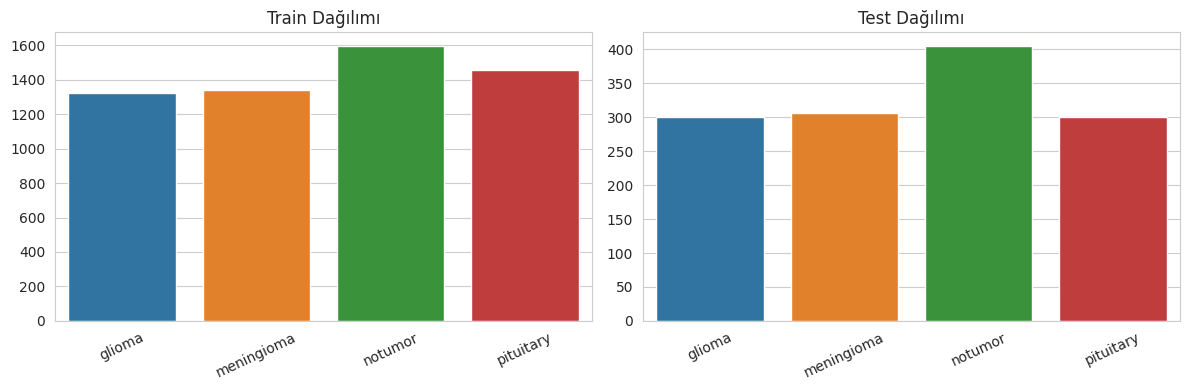

In [2]:
# =========================
# VERİ SAYIM & GÖRSELLEŞTİRME
# =========================
classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
print("Sınıflar:", classes)

def count_images(root, class_list):
    return {c: len(glob.glob(os.path.join(root, c, "*"))) for c in class_list}

train_counts = count_images(TRAIN_DIR, classes)
test_counts  = count_images(TEST_DIR,  classes)

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0])
ax[0].set_title("Train Dağılımı"); ax[0].tick_params(axis='x', rotation=25)
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1])
ax[1].set_title("Test Dağılımı"); ax[1].tick_params(axis='x', rotation=25)
plt.tight_layout(); plt.show()

# Örnek görseller
def sample_images(root, class_name, n=3):
    paths = glob.glob(os.path.join(root, class_name, "*"))
    picks = np.random.choice(paths, size=min(n,len(paths)), replace=False)
    imgs = [cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB) for p in picks]
    return imgs

plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    imgs = sample_images(TRAIN_DIR, cls, 3)
    for j, im in enumerate(imgs):
        plt.subplot(len(classes), 3, i*3+j+1)
        plt.imshow(im); plt.axis('off'); plt.title(cls)
plt.tight_layout(); plt.show()


## 3. Veri Ön İşleme ve Artırma (Data Augmentation)

Modelin genelleme kabiliyetini artırmak için **ImageDataGenerator** kullanılarak veri ön işleme ve artırma işlemleri yapıldı:

- **Rescale**: Tüm görsellerin piksel değerleri `[0,1]` aralığına indirildi.  
- **Augmentation**: Eğitim setinde küçük dönüşler, yakınlaştırma, yatay çevirme ve parlaklık değişimleri uygulandı. Bu sayede modelin farklı açılara ve ışık koşullarına karşı daha dayanıklı olması hedeflendi.  
- **Validation/Test**: Doğrulama ve test setlerinde yalnızca normalizasyon uygulandı, ek artırma yapılmadı.  

Ardından `flow_from_directory` ile klasörlerden veri jeneratörleri oluşturuldu. Eğitim ve doğrulama setleri `Training` klasöründen, test seti ise `Testing` klasöründen çekildi. Ayrıca sınıf etiketleri indekslere dönüştürülerek kaydedildi.


In [3]:
# =========================
# DATA AUGMENTATION
# =========================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=10,
    zoom_range=0.10,
    horizontal_flip=True,
    brightness_range=[0.8,1.2]  # color jitter basit parlaklık değişimi
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=VAL_SPLIT)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='categorical', subset='training', seed=SEED
)
val_gen = val_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='categorical', subset='validation', seed=SEED
)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH,
    class_mode='categorical', shuffle=False
)

class_indices = train_gen.class_indices
idx_to_class  = {v:k for k,v in class_indices.items()}
print("Class indices:", class_indices)


Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 4. CNN Modelinin Oluşturulması

Bu aşamada sınıflandırma için basit ama etkili bir **CNN (Convolutional Neural Network)** modeli tanımlandı:

- **Conv2D + MaxPooling**: Görsellerden temel ve ileri seviye özellikler çıkarılır.  
- **Dropout**: Rastgele nöronlar devre dışı bırakılarak overfitting azaltılır.  
- **Flatten**: Konvolüsyonel çıktılar düzleştirilir.  
- **Dense(128, ReLU + L2 regularizer)**: Tam bağlantılı katman ile öğrenme güçlendirilir.  
- **Dropout(0.5)**: Özellikle dense katmanda aşırı öğrenmenin önüne geçmek için kullanılır.  
- **Dense(n_classes, Softmax)**: Çıkış katmanı, her sınıf için olasılık değeri üretir.  

Bu yapı, overfitting’i engellemeye yönelik **dropout** ve **L2 regularization** teknikleriyle desteklenmiştir. Modelin özet tablosu `model.summary()` ile görüntülenmiştir.


In [4]:
# =========================
# CNN MODEL
# =========================
def build_cnn(input_shape=(224,224,3), n_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

model = build_cnn(input_shape=(224,224,3), n_classes=len(classes))
model.summary()


I0000 00:00:1758914515.416808      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,710,148 (98.08 MB)

 Trainable params: 25,710,148 (98.08 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Modelin Derlenmesi ve Eğitimi

Model **Adam** optimizatörü ile `learning_rate=0.001` kullanılarak derlendi. Kayıp fonksiyonu çok sınıflı sınıflandırmalar için uygun olan **categorical crossentropy** olarak seçildi. Performans ölçütü olarak **accuracy** kullanıldı.

Eğitim sürecinde modelin performansını iyileştirmek için üç callback tanımlandı:  
- **EarlyStopping**: Doğrulama kaybı belirli bir süre (6 epoch) iyileşmezse eğitimi durdurur ve en iyi ağırlıkları geri yükler.  
- **ReduceLROnPlateau**: Doğrulama kaybı 3 epoch boyunca iyileşmezse öğrenme oranını yarıya düşürür.  
- **ModelCheckpoint**: En iyi doğrulama sonucunu veren modeli dosyaya kaydeder.

Model 20 epoch boyunca eğitildi.


In [5]:
# =========================
# EĞİTİM
# =========================
model.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

history = model.fit(train_gen, validation_data=val_gen,
                    epochs=20, callbacks=callbacks)


Epoch 1/20


I0000 00:00:1758914520.607963     125 service.cc:148] XLA service 0x7efe2800b5c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758914520.609192     125 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758914520.969017     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/152 ━━━━━━━━━━━━━━━━━━━━ 18:46 7s/step - accuracy: 0.3750 - loss: 1.6345

I0000 00:00:1758914525.407865     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.5127 - loss: 1.4618 - val_accuracy: 0.7064 - val_loss: 1.0042 - learning_rate: 0.0010
Epoch 2/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 431ms/step - accuracy: 0.7360 - loss: 0.9249 - val_accuracy: 0.7240 - val_loss: 0.9205 - learning_rate: 0.0010
Epoch 3/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 67s 438ms/step - accuracy: 0.7646 - loss: 0.8287 - val_accuracy: 0.7883 - val_loss: 0.8768 - learning_rate: 0.0010
Epoch 4/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 64s 419ms/step - accuracy: 0.7694 - loss: 0.8426 - val_accuracy: 0.7988 - val_loss: 0.8915 - learning_rate: 0.0010
Epoch 5/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.8038 - loss: 0.8021 - val_accuracy: 0.8105 - val_loss: 0.8156 - learning_rate: 0.0010
Epoch 6/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 66s 435ms/step - accuracy: 0.7905 - loss: 0.8085 - val_accuracy: 0.8211 - val_loss: 0.7796 - learning_rate: 0.0010
Epoch 7/20
152/152 ━━━━━━━━━━━━━━━━━━━━ 63s 417ms/step - accuracy: 0.7969 - loss:

## 6. Eğitim Sürecinin Görselleştirilmesi

Eğitimden sonra modelin performansını daha iyi değerlendirmek için **accuracy** ve **loss** değerlerinin epoch’lara göre değişimi çizdirildi.

- **Train vs Validation Accuracy**: Eğitim doğruluğu ile doğrulama doğruluğu arasındaki fark, modelin aşırı öğrenip öğrenmediğini (overfitting) gösterir.  
- **Train vs Validation Loss**: Benzer şekilde kayıp değerlerinin eğilimi de öğrenmenin sağlıklı ilerleyip ilerlemediğini gösterir.  

**Yorumlama ipucu:**  
- Eğer eğitim doğruluğu yüksek, fakat doğrulama doğruluğu düşükse → **Overfitting**.  
- Hem eğitim hem doğrulama doğruluğu düşükse → **Underfitting**.  

Bu grafikler, modelin daha fazla eğitime, düzenlileştirmeye (regularization) veya veri artırmaya ihtiyaç duyup duymadığını anlamamızı sağlar.


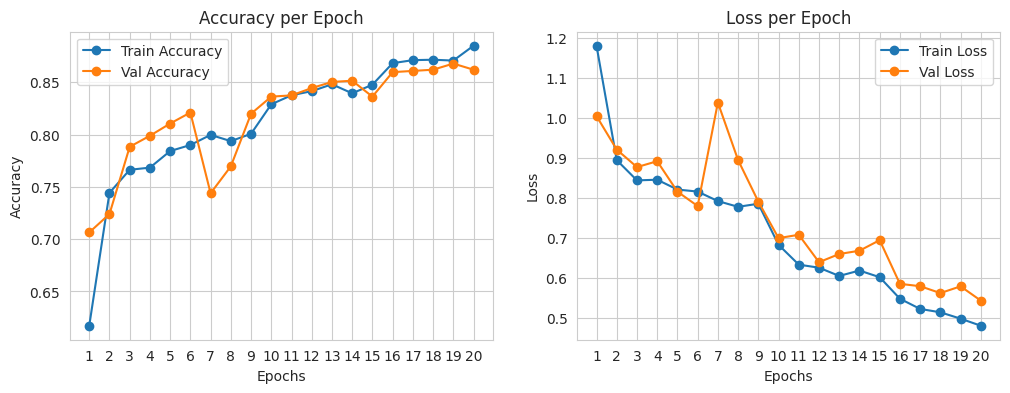

In [6]:
# =========================
# GRAFİKLER (OVERFIT/UNDERFIT YORUMU)
# =========================
def plot_history(h):
    epochs = range(1, len(h.history['accuracy']) + 1)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    ax[0].plot(epochs, h.history['accuracy'], label='Train Accuracy', marker='o')
    ax[0].plot(epochs, h.history['val_accuracy'], label='Val Accuracy', marker='o')
    ax[0].set_title("Accuracy per Epoch")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_xticks(list(epochs))   # X ekseni tam sayılar
    ax[0].legend()
    ax[0].grid(True)

    # Loss
    ax[1].plot(epochs, h.history['loss'], label='Train Loss', marker='o')
    ax[1].plot(epochs, h.history['val_loss'], label='Val Loss', marker='o')
    ax[1].set_title("Loss per Epoch")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].set_xticks(list(epochs))   # X ekseni tam sayılar
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

plot_history(history)

# Not: Train acc >> Val acc ise OVERFITTING, 
# ikisi de düşükse UNDERFITTING


## 7. Test Sonuçları ve Model Değerlendirmesi

Eğitim tamamlandıktan sonra model **test verisi** üzerinde değerlendirildi. Bu aşamada şu adımlar gerçekleştirildi:

- `model.evaluate`: Test seti için toplam **accuracy** ve **loss** değerleri hesaplandı.  
- **Tahminler**: Modelin tahmin ettiği sınıflar (`y_pred`) ile gerçek etiketler (`y_true`) karşılaştırıldı.  
- **Confusion Matrix**: Her sınıf için doğru ve yanlış tahmin sayıları görselleştirildi. Bu tablo, modelin hangi sınıflarda hata yaptığını görmemizi sağlar.  
- **Classification Report**: Her sınıf için **precision, recall, f1-score** ve destek (sample sayısı) metrikleri üretildi. Bu metrikler, modelin her bir sınıftaki başarısını detaylı şekilde gösterir.

Bu değerlendirmeler sayesinde modelin güçlü ve zayıf yönleri daha net bir şekilde analiz edilebilmektedir.


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - accuracy: 0.8230 - loss: 0.5781
Test Acc: 0.8749, Test Loss: 0.4756
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


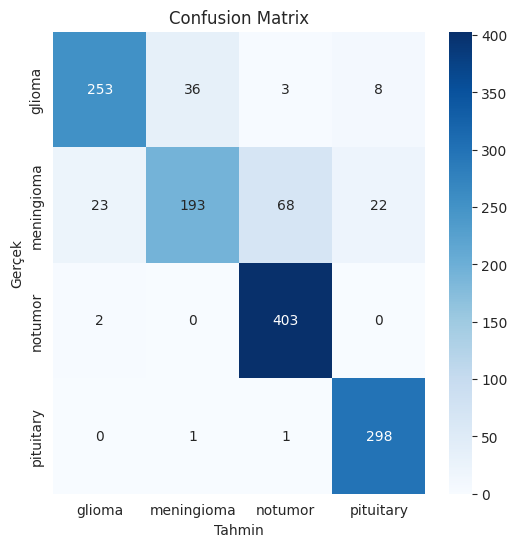

              precision    recall  f1-score   support

      glioma     0.9101    0.8433    0.8754       300
  meningioma     0.8391    0.6307    0.7201       306
     notumor     0.8484    0.9951    0.9159       405
   pituitary     0.9085    0.9933    0.9490       300

    accuracy                         0.8749      1311
   macro avg     0.8765    0.8656    0.8651      1311
weighted avg     0.8741    0.8749    0.8685      1311



In [7]:
# =========================
# TEST + CM + CR
# =========================
loss, acc = model.evaluate(test_gen)
print(f"Test Acc: {acc:.4f}, Test Loss: {loss:.4f}")

y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.title("Confusion Matrix"); plt.show()

print(classification_report(y_true, y_pred, target_names=classes, digits=4))


## 8. Grad-CAM ile Model Açıklanabilirliği

Modelin hangi bölgeleri kullanarak karar verdiğini anlamak için **Grad-CAM (Gradient-weighted Class Activation Mapping)** yöntemi uygulandı.  

- **Son Convolution Katmanı**: Öncelikle modeldeki son `Conv2D` katmanı belirlendi. Grad-CAM bu katmandaki özellik haritaları üzerinden çalışır.  
- **Grad-CAM Heatmap**: Seçilen örnek görüntü için modelin tahmin ettiği sınıfa ait gradyanlar hesaplandı. Bu gradyanlar, her özellik haritasının sınıf kararına katkısını gösterir.  
- **Özellik Haritalarının Ağırlıklandırılması**: Gradyan ortalamaları ile özellik haritaları çarpılarak sınıfa özgü bir önem haritası (heatmap) oluşturuldu.  
- **Normalizasyon ve Görselleştirme**: Heatmap normalize edilip orijinal görüntünün üzerine bindirildi. Böylece modelin hangi bölgelere odaklanarak doğru ya da yanlış tahmin yaptığı görselleştirildi.  

Sonuç olarak, hem **doğru sınıflandırılan** hem de **yanlış sınıflandırılan** örnekler üzerinde Grad-CAM uygulanarak modelin karar mekanizması incelendi.

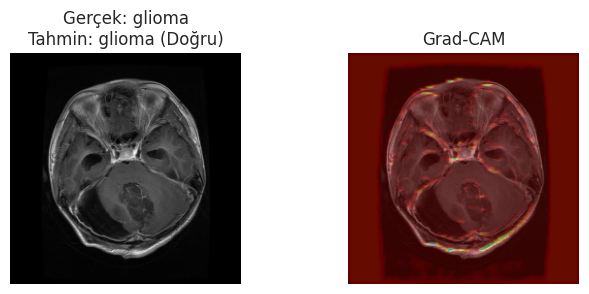

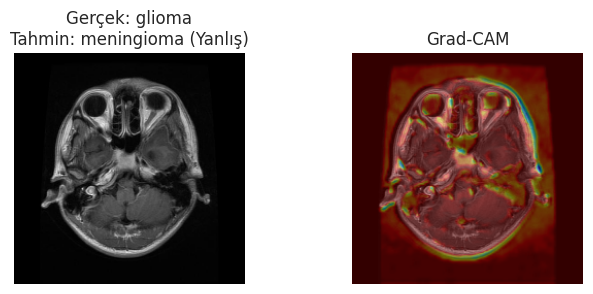

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers

# 1) Son convolution katmanı bulma
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError("Modelde Conv2D katmanı bulunamadı!")

# 2) Grad-CAM heatmap üretildi
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )

    with tf.GradientTape() as tape:
        conv_out, predictions = grad_model(img_array, training=False)
        class_idx = tf.argmax(predictions[0])
        class_channel = predictions[:, class_idx]

    # Gradient hesaplandı
    grads = tape.gradient(class_channel, conv_out)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Ağırlıklı özellik haritaları
    conv_out = conv_out[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_out, axis=-1)

    # Normalize edildi
    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap

# 3) Heatmap'i görselin üstüne bindirme
def overlay_heatmap(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1-alpha, heatmap_color, alpha, 0)
    return superimposed_img

# 4) Doğru ve yanlış örnek seçme
last_conv = get_last_conv_layer(model)

correct_idx = next((i for i,(t,p) in enumerate(zip(y_true, y_pred)) if t==p), None)
wrong_idx   = next((i for i,(t,p) in enumerate(zip(y_true, y_pred)) if t!=p), None)

for idx, tag in [(correct_idx, "Doğru"), (wrong_idx, "Yanlış")]:
    if idx is None: 
        continue
    # Orijinal görseli oku
    path = os.path.join(TEST_DIR, test_gen.filenames[idx])
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    resized = cv2.resize(img, (224,224))

    # Model için normalize edildi
    x = np.expand_dims(resized/255.0, axis=0)

    # Grad-CAM heatmap oluşturuldu
    heatmap = make_gradcam_heatmap(x, model, last_conv)
    overlay = overlay_heatmap(resized, heatmap)

    # Çizdirildi
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(resized)
    plt.title(f"Gerçek: {classes[y_true[idx]]}\nTahmin: {classes[y_pred[idx]]} ({tag})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()


## 9. Hiperparametre Optimizasyonu: Learning Rate & Batch Size

Model performansı, eğitim sürecinde kullanılan **hiperparametrelerden** doğrudan etkilenir. Bu nedenle farklı **learning rate (LR)** ve **batch size** değerleri denenerek en uygun kombinasyon araştırıldı.  

- **Learning Rate (LR)**: Öğrenme hızını belirler. Çok küçük olduğunda öğrenme yavaşlar, çok büyük olduğunda ise model kararsız hale gelebilir.  
- **Batch Size**: Eğitim sırasında aynı anda işlenen örnek sayısıdır. Küçük batch’ler daha gürültülü ama genelleştirici, büyük batch’ler ise daha stabil fakat daha fazla bellek tüketir.  

Bu çalışmada şu değerler test edilmiştir:  
- Learning Rate: **0.001, 0.01, 0.1**  
- Batch Size: **16, 32, 64**  

Her kombinasyon için model yeniden eğitilmiş, **en iyi doğrulama (validation) doğruluğu** kaydedilmiştir. Sonuçlar bir tablo halinde karşılaştırılarak en uygun LR & Batch Size ikilisi belirlenmiştir.


In [ ]:
# =========================
# Hiperparametre optimizasyonu: LR & Batch Size
# =========================
learning_rates = [0.001, 0.01, 0.1]   # küçük, orta, büyük değerler
batch_sizes    = [16, 32, 64]             # küçük, orta, büyük batch

results = {}

for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\n=== Eğitim Başladı: LR={lr}, Batch={bs} ===")

        # Model her deneme için yeniden oluşturuldu
        model = build_cnn(input_shape=(224,224,3), n_classes=len(classes))
        model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Data loader batch size’a göre ayarlandı
        train_gen_exp = train_datagen.flow_from_directory(
            TRAIN_DIR, target_size=IMG_SIZE, batch_size=bs,
            class_mode="categorical", subset="training", seed=SEED
        )
        val_gen_exp = val_datagen.flow_from_directory(
            TRAIN_DIR, target_size=IMG_SIZE, batch_size=bs,
            class_mode="categorical", subset="validation", seed=SEED
        )
        
        # Eğitim
        hist = model.fit(train_gen_exp, validation_data=val_gen_exp,
                         epochs=20, verbose=0)  # kısa tutmak için 10 epoch
        best_val_acc = max(hist.history['val_accuracy'])
        results[f"lr={lr}_bs={bs}"] = best_val_acc

# Sonuçlar tabloya döküldü
import pandas as pd
pd.DataFrame(results.items(), columns=["Deneme", "Val_Accuracy"])




=== Eğitim Başladı: LR=0.001, Batch=16 ===
Found 4857 images belonging to 4 classes.
Found 855 images belonging to 4 classes.
